In [32]:
import pandas as pd
import json
import time
import random
from datetime import datetime
import csv
import os
import logging
import seaborn as sns

#logging.basicConfig(filename='Model.log', encoding='utf-8', level=logging.INFO)

In [2]:
df = pd.read_csv('Flight_data_with_MODEL_&_WEATHER.csv', low_memory=False, dtype='unicode')

In [16]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 762573 entries, 0 to 762572
Data columns (total 144 columns):
 #    Column                                              Non-Null Count   Dtype 
---   ------                                              --------------   ----- 
 0    Year                                                762573 non-null  object
 1    Quarter                                             762573 non-null  object
 2    Month                                               762573 non-null  object
 3    DayofMonth                                          762573 non-null  object
 4    DayOfWeek                                           762573 non-null  object
 5    FlightDate                                          762573 non-null  object
 6    Marketing_Airline_Network                           762573 non-null  object
 7    Operated_or_Branded_Code_Share_Partners             762573 non-null  object
 8    DOT_ID_Marketing_Airline                            762573 non

In [13]:
df['model']

0                 NaN
1         CL-600-2B19
2         CL-600-2C10
3                 NaN
4                E170
             ...     
762568            NaN
762569            NaN
762570            NaN
762571        737-7H4
762572        737-8H4
Name: model, Length: 762573, dtype: object

In [41]:
# 需定义啥叫延误，这里以0为阈值，<=0的视为没有延误（0）   >0的视为延误（1）
df['is_delay'] = df['ArrDelay'].apply(lambda x: 0 if float(x)<=0 else 1)

## EDA

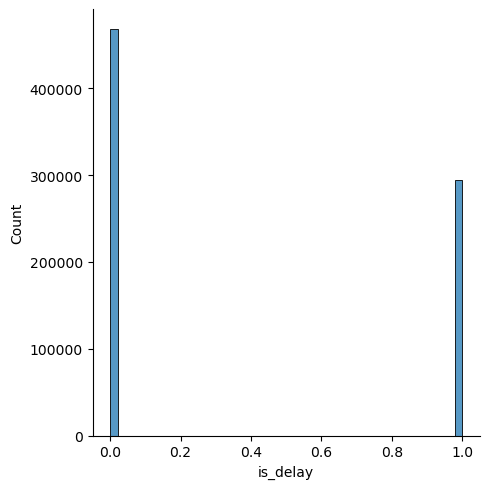

In [33]:
sns.displot(data=df, x='is_delay')

## 特征工程


### 选择建模变量

In [47]:
from sklearn import preprocessing

In [46]:
# 'Marketing_Airline_Network'与'Flight_Number_Marketing_Airline'对应，但后者是数字型，去除哦。使用前者one-hot
# DepDelay对于决定Arrival delay 太重要了，是否放在变量里？

variable_columns = ['Year','Quarter','Month','DayofMonth','DayOfWeek','Marketing_Airline_Network',
                    'OriginAirportID','DestAirportID','DepTime','DepDelay','ArrTime',
                    'Distance','temp','dwpt','rhum','prcp','wspd','wdir','pres','model',
                   'is_delay']


In [103]:
train = df[variable_columns].copy()
train.head()

,Year,Quarter,Month,DayofMonth,DayOfWeek,Marketing_Airline_Network,OriginAirportID,DestAirportID,DepTime,DepDelay,...,Distance,temp,dwpt,rhum,prcp,wspd,wdir,pres,model,is_delay
0,2021,4,10,22,5,G4,11986,10423,0824,-3.00,...,1103.00,5.9,-8.1,36.0,0.0,14.8,190.0,1016.9,NaN,0
1,2021,4,10,16,6,UA,12197,13930,0621,-9.00,...,738.00,22.8,21.1,90.0,0.0,0.0,0.0,1013.2,CL-600-2B19,0
2,2021,4,10,3,7,DL,12339,11433,1406,-4.00,...,231.00,28.9,23.3,72.0,0.0,24.1,70.0,1015.3,CL-600-2C10,0
3,2021,4,10,11,1,F9,11292,14107,2241,-4.00,...,602.00,27.2,3.0,21.0,0.0,29.5,200.0,996.3,NaN,1
4,2021,4,10,7,4,UA,14986,11618,1433,-7.00,...,1034.00,24.4,15.6,58.0,0.0,7.6,20.0,1025.0,E170,0


#### Marketing_Airline_Network /运营商

In [104]:
train['Marketing_Airline_Network'].unique()

array(['G4', 'UA', 'DL', 'F9', 'B6', 'AA', 'AS', 'WN', 'NK', 'HA'],
      dtype=object)

Marketing_Airline_Network 的分类数较少，直接使用get_dummy one-hot编码

In [105]:
train = pd.get_dummies(data=train, columns=['Marketing_Airline_Network'])
train.head()

,Year,Quarter,Month,DayofMonth,DayOfWeek,OriginAirportID,DestAirportID,DepTime,DepDelay,ArrTime,...,Marketing_Airline_Network_AA,Marketing_Airline_Network_AS,Marketing_Airline_Network_B6,Marketing_Airline_Network_DL,Marketing_Airline_Network_F9,Marketing_Airline_Network_G4,Marketing_Airline_Network_HA,Marketing_Airline_Network_NK,Marketing_Airline_Network_UA,Marketing_Airline_Network_WN
0,2021,4,10,22,5,11986,10423,0824,-3.00,1014,...,0,0,0,0,0,1,0,0,0,0
1,2021,4,10,16,6,12197,13930,0621,-9.00,0745,...,0,0,0,0,0,0,0,0,1,0
2,2021,4,10,3,7,12339,11433,1406,-4.00,1516,...,0,0,0,1,0,0,0,0,0,0
3,2021,4,10,11,1,11292,14107,2241,-4.00,2350,...,0,0,0,0,1,0,0,0,0,0
4,2021,4,10,7,4,14986,11618,1433,-7.00,1713,...,0,0,0,0,0,0,0,0,1,0


#### OriginAirportID / DestAirportID

In [106]:
train['OriginAirportID'].nunique()

378

OriginAirportID 的编码虽然是数字，但本质还是categorical类型。

1. 直接数字，由于数值较大（上万），模型可能会把数值大小作为特征学习了
2. 使用get_dummy,产生 370 * 2 列的one-hot编码，太多了

所以，这里初步使用LabelEncoder进行编码

In [107]:
# 编码OriginAirport
le_OriginAir = preprocessing.LabelEncoder()
le_OriginAir.fit(train['OriginAirportID'])

train['OriginAirportID'] = le_OriginAir.transform(train['OriginAirportID'])

# 编码DestAirport
le_DestAir = preprocessing.LabelEncoder()
le_DestAir.fit(train['DestAirportID'])

train['DestAirportID'] = le_DestAir.transform(train['DestAirportID'])

#### model 飞机型号

In [101]:
tmp = train.groupby('model').count()[['Year']]

In [102]:
tmp = tmp.reset_index()
tmp = tmp.sort_values(by='Year', ascending=False)
tmp.head(20)

,model,Year
77,B737,37242
78,B738,31161
16,737-7H4,28851
96,CL-600-2D24,26693
117,ERJ 170-200 LR,26604
94,CL-600-2B19,21461
60,A320,20797
27,737-8H4,18497
99,CRJ2,17371
64,A320-232,17167


有点麻烦，有很多相似的不知道能不能合并，比如A320和A320-232

这里也用LabelEncoder编码先

In [108]:
# 编码OriginAirport
le_model = preprocessing.LabelEncoder()
le_model.fit(train['model'])

train['model'] = le_model.transform(train['model'])

#### DepTime/ArrTime 等

时间日期值怎么做特征呢？

不知道，先直接用试试

#### 去除空值

In [109]:
train.dropna(inplace=True)

In [115]:
#保存此次训练集
train.to_csv('Train_Dataset_1021.csv', index = False)

## 建模

参考官网发布的[算法选择](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html)

这里用LinearSVC进行二分类任务建模

In [110]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 741347 entries, 0 to 762572
Data columns (total 30 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   Year                          741347 non-null  object
 1   Quarter                       741347 non-null  object
 2   Month                         741347 non-null  object
 3   DayofMonth                    741347 non-null  object
 4   DayOfWeek                     741347 non-null  object
 5   OriginAirportID               741347 non-null  int32 
 6   DestAirportID                 741347 non-null  int32 
 7   DepTime                       741347 non-null  object
 8   DepDelay                      741347 non-null  object
 9   ArrTime                       741347 non-null  object
 10  Distance                      741347 non-null  object
 11  temp                          741347 non-null  object
 12  dwpt                          741347 non-null  object
 13 

In [111]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification

In [112]:
X=train.drop(['is_delay'], axis=1)
y=train['is_delay']

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

In [114]:
clf = make_pipeline(StandardScaler(),
                    LinearSVC(random_state=0, tol=1e-5))
clf.fit(X_train, y_train)

D:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(random_state=0, tol=1e-05))])

In [118]:
predictions = clf.predict(X_test)

In [119]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test,predictions))

[[133718   6332]
 [ 29559  52796]]


In [120]:
from sklearn.metrics import classification_report

print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.82      0.95      0.88    140050
           1       0.89      0.64      0.75     82355

    accuracy                           0.84    222405
   macro avg       0.86      0.80      0.81    222405
weighted avg       0.85      0.84      0.83    222405



## 保存/加载模型

In [122]:
import pickle

In [123]:
# 保存模型
model_folder = 'Model'
model_filename = "LinearSVCModel_with_DepDelay.pkl"

with open(os.path.join(model_folder,model_filename), 'wb') as file:
    pickle.dump(clf, file)


In [126]:
# 加载模型
model_folder = 'Model'
model_filename = "LinearSVCModel_with_DepDelay.pkl"

with open(os.path.join(model_folder,model_filename), 'rb') as file:
    pickle_model = pickle.load(file)

predictions = clf.predict(X_test)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.82      0.95      0.88    140050
           1       0.89      0.64      0.75     82355

    accuracy                           0.84    222405
   macro avg       0.86      0.80      0.81    222405
weighted avg       0.85      0.84      0.83    222405

